In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Elianna/HousePrice_Kaggle/Kaggle-House-Price-ML

/content/gdrive/My Drive/Elianna/HousePrice_Kaggle/Kaggle-House-Price-ML


In [21]:
#libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
pd.options.mode.chained_assignment = None
import h2o
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [22]:
train = pd.read_csv('./house-prices-data/train.csv') 
test = pd.read_csv('./house-prices-data/test.csv')

In [23]:
## DATA CLEANING AND FEATURE ENGINEERING

In [24]:
# Drop the id column from both test and training data
train.drop(['Id'],axis=1, inplace=True)
test.drop(['Id'],axis=1, inplace=True)

In [25]:
print('The shape of train data is {}'.format(train.shape))
print('The shape of test data is {}'.format(test.shape))

The shape of train data is (1460, 80)
The shape of test data is (1459, 79)


In [26]:
#concat both the datasets for easier cleaning 
full = train.append(test, ignore_index=True)

In [27]:
print('The shape of full data is {}'.format(full.shape))

The shape of full data is (2919, 80)


In [28]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


### Cleaning Data Set


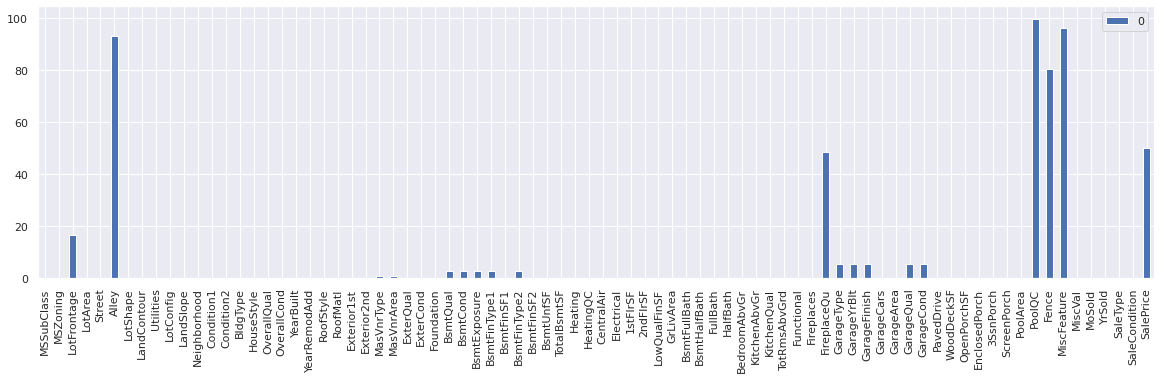

In [29]:
pd.DataFrame(full.isna().sum()*100/full.shape[0]).plot.bar(figsize=(20,5))

* The above plot gives us a summary as percent values for all the variables in the training dataset. 
* For the variables with huge proportion of missing value: Alley, PoolQC, Fence and MiscFeature, it's proper to replace NA value with **None**. Since **None** is also a type
* Replaced null values with None in the FireplaceQu column both in test and training set.

### Imputing Missing Values & Data Engineering

In [30]:
#NA already existing category
full.update(full[['BsmtCond','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtQual','GarageType','GarageQual','GarageFinish','GarageCond','FireplaceQu','MiscFeature','Fence','PoolQC','Alley']].fillna('None'))

#none a new category generated
full.update(full[['Electrical','MasVnrType']].fillna('None'))

#nan with zero as constant
full.update(full[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','MasVnrArea','TotalBsmtSF']].fillna(0)) #no basement so areas are zero

In [31]:
# Replacing the missing values with mode for the list of variables ['Exterior1st','Exterior2nd','Functional','KitchenQual','MSZoning','SaleType','Utilities']
full['Exterior1st']=full['Exterior1st'].fillna(full.Exterior1st.value_counts().index[0])
full['Exterior2nd']=full['Exterior2nd'].fillna(full.Exterior2nd.value_counts().index[0])
full['Functional']=full['Functional'].fillna(full.Functional.value_counts().index[0])
full['KitchenQual']=full['KitchenQual'].fillna(full.KitchenQual.value_counts().index[0])
full['MSZoning']=full['MSZoning'].fillna(full.MSZoning.value_counts().index[0])
full['SaleType']=full['SaleType'].fillna(full.SaleType.value_counts().index[0])
full['Utilities']=full['Utilities'].fillna(full.Utilities.value_counts().index[0])

#Dropping irrelavent columns from the whole dataset based on the EDA on the training dataset
full= full.drop(['MoSold','GarageQual','PoolArea','MSSubClass'],axis=1)

#GarageQual is repetitive
#PoolQC is mostly NA
#Pool Area is mostly 0
#MSSubClass is a combination of dweiing and year

In [32]:
#filled missing garage years
full['GarageYrBlt'] = full['GarageYrBlt'].fillna(full['YearBuilt'])

In [33]:
#converting years into age 
currentYear = datetime.now().year

full['Age_House']=currentYear-full['YearBuilt']
full['Age_Renovation']=currentYear-full['YearRemodAdd']
full['Garage_age']=currentYear-full['GarageYrBlt']
full = full.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

In [36]:
# Changing OverallCond into a categorical variable
full['OverallCond'] = full['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
full['YrSold'] = full['YrSold'].astype(str)

In [39]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageCond', 'ExterQual', 
        'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'OverallCond', 
        'YrSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lb = LabelEncoder() 
    lb.fit(list(full[c].values)) 
    full[c] = lb.transform(list(full[c].values))

In [40]:
# Adding total sqfootage feature 
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']

In [41]:
full.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,Age_House,Age_Renovation,Garage_age,TotalSF
0,RL,65.0,8450,1,1,3,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,2,4,PConc,2,4,3,2,706.0,6,0.0,150.0,856.0,GasA,0,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,Attchd,2,2.0,548.0,5,2,0,61,0,0,0,3,4,None,0,2,WD,Normal,208500.0,17,17,17.0,2566.0
1,RL,80.0,9600,1,1,3,Lvl,AllPub,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,CBlock,2,4,1,0,978.0,6,0.0,284.0,1262.0,GasA,0,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,Attchd,2,2.0,460.0,5,2,298,0,0,0,0,3,4,None,0,1,WD,Normal,181500.0,44,44,44.0,2524.0
2,RL,68.0,11250,1,1,0,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,2,4,PConc,2,4,2,2,486.0,6,0.0,434.0,920.0,GasA,0,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,Attchd,2,2.0,608.0,5,2,0,42,0,0,0,3,4,None,0,2,WD,Normal,223500.0,19,18,19.0,2706.0
3,RL,60.0,9550,1,1,0,Lvl,AllPub,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,4,BrkTil,4,1,3,0,216.0,6,0.0,540.0,756.0,GasA,2,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,Detchd,3,3.0,642.0,5,2,0,35,272,0,0,3,4,None,0,0,WD,Abnorml,140000.0,105,50,22.0,2473.0
4,RL,84.0,14260,1,1,0,Lvl,AllPub,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,2,4,PConc,2,4,0,2,655.0,6,0.0,490.0,1145.0,GasA,0,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,Attchd,2,3.0,836.0,5,2,192,84,0,0,0,3,4,None,0,2,WD,Normal,250000.0,20,20,20.0,3343.0


In [42]:
#spillitng the data again

train = full[full['SalePrice'].notnull()]
test = full[full['SalePrice'].isnull()]

In [43]:
train_y = train['SalePrice']
train_x = train.drop(['SalePrice'],axis=1)

In [44]:
test_x = test.drop(['SalePrice'],axis=1)

In [45]:
test_x.shape

(1459, 76)

In [46]:
train_x.shape

(1460, 76)

In [47]:
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(train_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Training data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Training data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

0.9305840449585167

In [48]:
# Predict training data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
train_x.loc[train_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

In [49]:
# Repeat same process for test data
# Get train LotFrontage dummy variables
LotFrontage_Dummies_df = pd.get_dummies(test_x[['LotFrontage', 'MSZoning', 'LotArea', 'LotConfig', 'Neighborhood']])

# Get full dummy variables
# Split the data into LotFrontage known and LotFrontage unknown
LotFrontageKnown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].notnull()]
LotFrontageUnknown = LotFrontage_Dummies_df[LotFrontage_Dummies_df["LotFrontage"].isnull()]

# Testing data knowing LotFrontage
LotFrontage_Known_X = LotFrontageKnown.drop(["LotFrontage"], axis = 1)
LotFrontage_Known_y = LotFrontageKnown["LotFrontage"]
# Testing data unknown LotFrontage
LotFrontage_Unknown_X = LotFrontageUnknown.drop(["LotFrontage"], axis = 1)
# Build model using random forest
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=1,n_estimators=500,n_jobs=-1)
rfr.fit(LotFrontage_Known_X, LotFrontage_Known_y)
rfr.score(LotFrontage_Known_X, LotFrontage_Known_y)

0.9456107979297688

In [50]:
# Predict testing data unknown LotFrontage
LotFrontage_Unknown_y = rfr.predict(LotFrontage_Unknown_X)
test_x.loc[test_x["LotFrontage"].isnull(), "LotFrontage"] = LotFrontage_Unknown_y

In [51]:
train['LotFrontage'] = train_x['LotFrontage']
test['LotFrontage'] = test_x['LotFrontage']

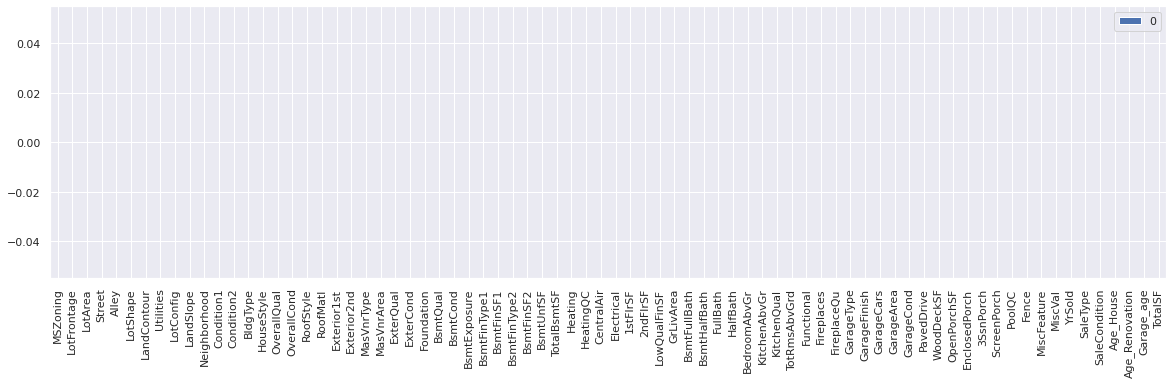

In [52]:
pd.DataFrame(train_x.isna().sum()*100/train_x.shape[0]).plot.bar(figsize=(20,5))

In [53]:
train.to_csv('processed-data/new_train.csv', index=False)
test.to_csv('processed-data/new_test.csv', index=False)

In [54]:
train.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,SalePrice,Age_House,Age_Renovation,Garage_age,TotalSF
0,RL,65.0,8450,1,1,3,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,2,4,PConc,2,4,3,2,706.0,6,0.0,150.0,856.0,GasA,0,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,Attchd,2,2.0,548.0,5,2,0,61,0,0,0,3,4,None,0,2,WD,Normal,208500.0,17,17,17.0,2566.0
1,RL,80.0,9600,1,1,3,Lvl,AllPub,FR2,0,Veenker,Feedr,Norm,1Fam,1Story,6,7,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,CBlock,2,4,1,0,978.0,6,0.0,284.0,1262.0,GasA,0,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,Attchd,2,2.0,460.0,5,2,298,0,0,0,0,3,4,None,0,1,WD,Normal,181500.0,44,44,44.0,2524.0
2,RL,68.0,11250,1,1,0,Lvl,AllPub,Inside,0,CollgCr,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,2,4,PConc,2,4,2,2,486.0,6,0.0,434.0,920.0,GasA,0,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,Attchd,2,2.0,608.0,5,2,0,42,0,0,0,3,4,None,0,2,WD,Normal,223500.0,19,18,19.0,2706.0
3,RL,60.0,9550,1,1,0,Lvl,AllPub,Corner,0,Crawfor,Norm,Norm,1Fam,2Story,7,4,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,4,BrkTil,4,1,3,0,216.0,6,0.0,540.0,756.0,GasA,2,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,Detchd,3,3.0,642.0,5,2,0,35,272,0,0,3,4,None,0,0,WD,Abnorml,140000.0,105,50,22.0,2473.0
4,RL,84.0,14260,1,1,0,Lvl,AllPub,FR2,0,NoRidge,Norm,Norm,1Fam,2Story,8,4,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,2,4,PConc,2,4,0,2,655.0,6,0.0,490.0,1145.0,GasA,0,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,Attchd,2,3.0,836.0,5,2,192,84,0,0,0,3,4,None,0,2,WD,Normal,250000.0,20,20,20.0,3343.0
